## Load the dataset

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Adjust the separator to tab if your data is tab-separated
normalized_data_path = '../Normalization/UCI_Real_Estate_normalized.csv'
data = pd.read_csv(normalized_data_path, sep=',', header=0)

# Print the first few rows of the DataFrame to verify correct loading
print(data.head())



         No  X1 transaction date  X2 house age  \
0  0.000000             0.272727      0.730594   
1  0.002421             0.272727      0.445205   
2  0.004843             1.000000      0.303653   
3  0.007264             0.909091      0.303653   
4  0.009685             0.181818      0.114155   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                0.009513                              1.0   
1                                0.043809                              0.9   
2                                0.083315                              0.5   
3                                0.083315                              0.5   
4                                0.056799                              0.5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     0.616941      0.719323                    0.275705  
1     0.584949      0.711451                    0.314832  
2     0.671231      0.758896                    0.361

## Data Preprocessing

In [5]:
data = data.drop(['No'], axis=1)

X = data.drop('Y house price of unit area', axis=1)  # All columns except the target
y = data['Y house price of unit area']  # Only the target column


# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Display the shape of the train and test sets to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (331, 6) (331,)
Testing set shape: (83, 6) (83,)


## Model Training

In [6]:
# Initialize the Linear Regression model
mlr_model = LinearRegression()

# Fit the model to the training data
mlr_model.fit(X_train, y_train)

# Display the coefficients of the model
print("Coefficients:", mlr_model.coef_)
print("Intercept:", mlr_model.intercept_)


Coefficients: [ 0.04540179 -0.10792348 -0.2799196   0.09931476  0.17198478 -0.02489667]
Intercept: 0.24025566700226342


## Model Evaluation

In [7]:
# Make predictions on the testing set
y_pred = mlr_model.predict(X_test)

# Calculate and print the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 0.004429724131805037
R^2 Score: 0.6810781244679084


## Visualization

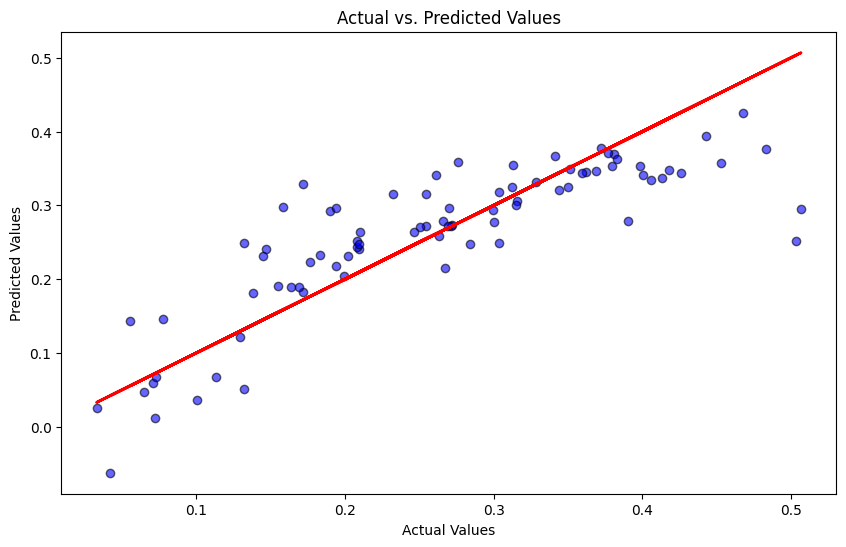

In [8]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.6)
plt.plot(y_test, y_test, color='red', linewidth=2)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()
